In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
import altair
import seaborn
RANDOM_SEED = 511
rng = np.random.default_rng(RANDOM_SEED)
seaborn.set_theme(style="darkgrid")
altair.renderers.enable('mimetype')

db_url: str = os.getenv('DB_URL')

%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
from lib import wrap_labels, adjust_pairplot_axes

In [26]:
# OTP concentration by 

sql = """
select
    uhf_name || ' (' || borough_name || ')' AS Neighborhood,
    100 * coalesce(total_admissions_3_2019, 0) :: float / sum(total_admissions_3_2019) over () as "Opioid Treatment Admissions (2019)",
    100 * coalesce(overdose_deaths_2020, 0) :: float / sum(overdose_deaths_2020) over () as "Overdose Deaths (2020)",
    100 * coalesce(opioid_burden_2019, 0) :: float / sum(opioid_burden_2019) over () as "Opioid Burden (2019)",
    100 * coalesce(patient_admissions_3_2019, 0) :: float / sum(patient_admissions_3_2019) over () as "Patient Population (2019)",
    100 * population_2020_estimate :: float / sum(population_2020_estimate) over () as "Population (2020)"
from uhf_otp_analysis
order by 4 desc
limit 10
"""
uhf_od_df = pd.read_sql(sql, con=db_url)
uhf_od_df.head(3).T


,0,1,2
neighborhood,Crotona - Tremont (Bronx),High Bridge - Morrisania (Bronx),Fordham - Bronx Park (Bronx)
Opioid Treatment Admissions (2019),10.636136,6.08784,0.63301
Overdose Deaths (2020),6.711409,5.536913,5.145414
Opioid Burden (2019),7.232913,6.220969,5.383212
Patient Population (2019),7.668313,7.443029,4.87826
Population (2020),2.526588,2.565256,3.178876


''

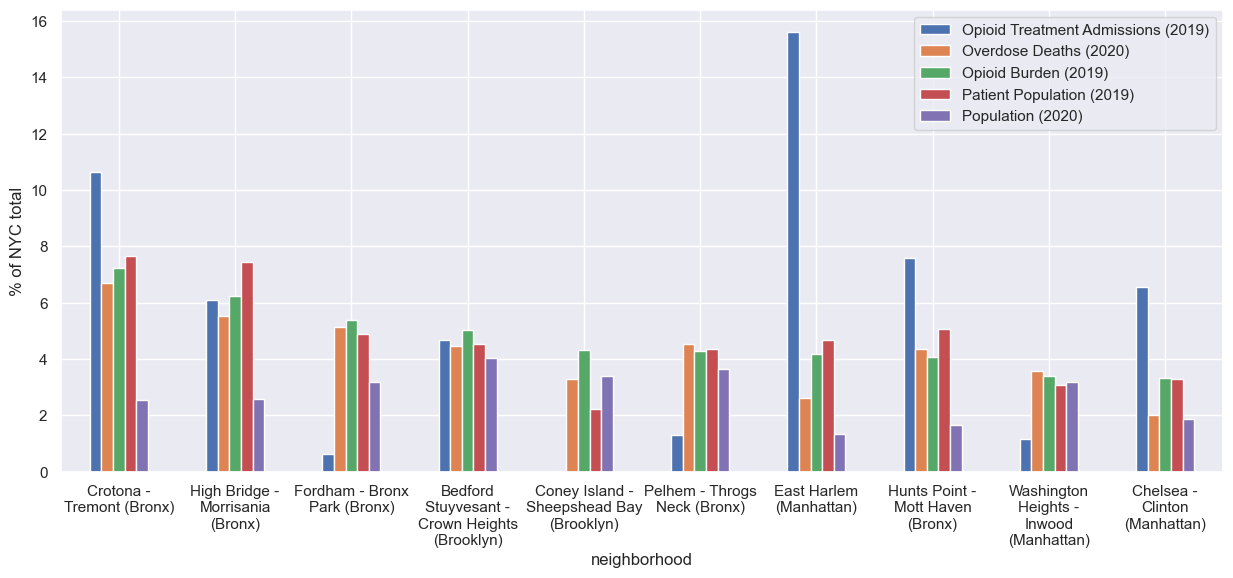

In [20]:
ax = uhf_od_df.plot(kind='bar', x='neighborhood', figsize=(15, 6), ylabel=r'% of NYC total')
wrap_labels(ax, 15)
;

In [60]:
sql = """
with by_zip as (
    SELECT
        is_harlem,
        borough_name,
        100 * sum(population_2020_estimate) :: float / sum(sum(population_2020_estimate)) over () as population_2020_estimate,
        100 * sum(total_admissions_3_2019) :: float / sum(sum(total_admissions_3_2019)) over () AS total_admissions_3_2019,
        100 * sum(otp_capacity) :: float / sum(sum(otp_capacity)) over () AS otp_capacity,
        100 * sum(avg_daily_enrollment_2019) :: float / sum(sum(avg_daily_enrollment_2019)) over () AS avg_daily_enrollment_2019,
        100 * sum(patient_admissions_3_2019) :: float / sum(sum(patient_admissions_3_2019)) over () AS patient_admissions_3_2019,
        100 * sum(opioid_burden_2019) :: float / sum(sum(opioid_burden_2019)) over () AS opioid_burden_2019
    FROM zip_code_otp_analysis
    GROUP BY 1, 2
), by_uhf as (
    SELECT
        is_harlem,
        borough_name,
        100 * sum(overdose_deaths_2020) :: float / sum(sum(overdose_deaths_2020)) over () as overdose_deaths_2020
    FROM uhf_otp_analysis
    GROUP BY 1, 2
)
, combined as (
    select
        --CASE WHEN borough_name = 'Manhattan' THEN 'Manhattan (incl. Harlem)' 
        --    ELSE borough_name END as borough_name,
        borough_name,
        --sum(total_admissions_3_2019) AS "OTP Admissions (2019)",
        sum(otp_capacity) AS "OTP Capacity (2019)",
        --sum(avg_daily_enrollment_2019) AS "OTP Daily Enrollment (2019)",
        --sum(patient_admissions_3_2019) AS "OTP Patient Population (2019)",
        --sum(opioid_burden_2019) AS "Opioid Burden (2019)",
        sum(overdose_deaths_2020) AS "Overdose Deaths (2020)",
        sum(population_2020_estimate) AS "Population (2020)"
    from by_zip
        full outer join by_uhf using (is_harlem, borough_name)
    -- where not is_harlem
    group by 1

    union

    select
        'Harlem Alone' AS borough_name,
        --sum(total_admissions_3_2019) AS "OTP Admissions (2019)",
        sum(otp_capacity) AS "OTP Capacity (2019)",
        --sum(avg_daily_enrollment_2019) AS "OTP Daily Enrollment (2019)",
        --sum(patient_admissions_3_2019) AS "OTP Patient Population (2019)",
        --sum(opioid_burden_2019) AS "Opioid Burden (2019)",
        sum(overdose_deaths_2020) AS "Overdose Deaths (2020)",
        sum(population_2020_estimate) AS "Population (2020)"
    from by_zip
        join by_uhf using (is_harlem, borough_name)
    where is_harlem
    group by 1
)
select * from combined order by "Overdose Deaths (2020)" desc
"""
borough_od_df = pd.read_sql(sql, con=db_url)
borough_od_df.head(3).T

,0,1,2
borough_name,Bronx,Brooklyn,Queens
OTP Capacity (2019),31.338006,21.434383,4.978409
Overdose Deaths (2020),29.9217,23.657718,20.0783
Population (2020),17.138887,30.8477,27.117191


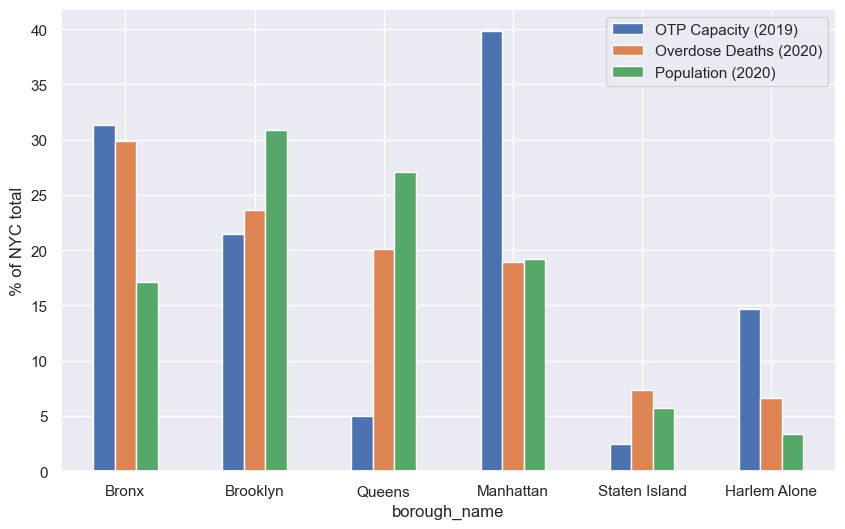

In [61]:
ax = borough_od_df.plot(kind='bar', x='borough_name', figsize=(10, 6), ylabel=r'% of NYC total')
wrap_labels(ax, 15)

In [8]:

sql = """
with enrollment as (
    select
        p.borough_name,
        c.year,
        SUM(c.avg_daily_enrollment) AS enrollment
    from enrollment_by_year c
        join programs as p using (program_number)
    where p.program_category = 'Opioid Treatment Program'
    group by 1, 2
)
select
    year,
    sum(case when borough_name = 'Bronx' then enrollment end) as "Bronx",
    sum(case when borough_name = 'Brooklyn' then enrollment end) as "Brooklyn",
    sum(case when borough_name = 'Manhattan' then enrollment end) as "Manhattan",
    sum(case when borough_name = 'Queens' then enrollment end) as "Queens",
    sum(case when borough_name = 'Staten Island' then enrollment end) as "Staten Island"
from enrollment AS e
where year in (2010, 2015, 2019)
group by 1
order by 1

"""
enrollment_df = pd.read_sql(sql, con=db_url)
enrollment_df.head(3).T

,0,1,2
year,2010.0,2015.0,2019.0
Bronx,9230.0,13644.0,9489.0
Brooklyn,8723.0,7324.0,6093.0
Manhattan,12330.0,11493.0,11237.0
Queens,2834.0,1904.0,1614.0
Staten Island,649.0,716.0,724.0


In [13]:
sql = """

with ods as (
    select
        borough_name,
        year,
        deaths
    from ny_county_od_trend
    where is_nyc
)
select
    year,
    sum(case when borough_name = 'Bronx' then deaths end) as "Bronx",
    sum(case when borough_name = 'Brooklyn' then deaths end) as "Brooklyn",
    sum(case when borough_name = 'Manhattan' then deaths end) as "Manhattan",
    sum(case when borough_name = 'Queens' then deaths end) as "Queens",
    sum(case when borough_name = 'Staten Island' then deaths end) as "Staten Island"
from ods AS e
group by 1
order by 1
"""
od_df = pd.read_sql(sql, con=db_url)
od_df.head(3).T

,0,1,2
year,2010,2011,2012
Bronx,71,93,109
Brooklyn,130,137,141
Manhattan,50,64,109
Queens,87,90,94
Staten Island,47,66,67


In [14]:
sql = """
with enrollment as (
    select
        p.borough_name,
        c.year,
        SUM(c.avg_daily_enrollment) AS enrollment
    from chan_foil c
        join programs as p using (program_number)
    where p.program_category = 'Opioid Treatment Program'
    group by 1, 2
),
e_and_od as (
    select 
        borough_name,
        year,
        enrollment,
        ny_county_od_trend.deaths
    from enrollment
        join ny_county_od_trend using (borough_name, year)

    union 
    
    select 
        'NYC Total',
        year,
        sum(enrollment) as enrollment,
        sum(ny_county_od_trend.deaths) as deaths
    from enrollment
        join ny_county_od_trend using (borough_name, year)
    group by year
)
select
    e2010.borough_name,
    -- e2010.enrollment as enrollment_2010,
    -- e2019.enrollment as enrollment_2019,
    -- e2019.enrollment - e2010.enrollment as enrollment_delta,
    -- e2010.deaths as deaths_2010,
    -- e2019.deaths as deaths_2019,
    -- e2019.deaths - e2010.deaths as deaths_delta,
    100 * (e2019.enrollment - e2010.enrollment)::float / e2010.enrollment as enrollment_pct_change,
    100 * (e2019.deaths - e2010.deaths)::float / e2010.deaths as deaths_pct_change
FROM e_and_od as e2010
join e_and_od as e2019
    on e2010.borough_name = e2019.borough_name
    and e2010.year = 2010 and e2019.year = 2019
"""

enrollment_od_df = pd.read_sql(sql, con=db_url)
enrollment_od_df


,borough_name,enrollment_pct_change,deaths_pct_change
0,NYC Total,-13.649825,201.818182
1,Staten Island,11.556240,117.021277
2,Queens,-43.048694,120.689655
3,Bronx,2.806067,381.690141
4,Manhattan,-8.864558,396.000000
5,Brooklyn,-30.150178,113.846154


In [16]:
sql = """
with enrollment as (
    select
        p.borough_district_code,
        c.year,
        SUM(c.avg_daily_enrollment) AS enrollment
    from enrollment_by_year c
        join programs as p using (program_number)
        join districts as d on p.borough_district_code = d.borough_district_code
    where p.program_category = 'Opioid Treatment Program'
    group by 1, 2
)
select
    d.borough_district_code "Boro CD code",
    d.district_name as "District Name",
    coalesce(e2010.enrollment, 0) as "2010 Daily Avg. Enrollment",
    coalesce(e2019.enrollment, 0) as "2019 Daily Avg. Enrollment",
    coalesce(e2019.enrollment, 0) - coalesce(e2010.enrollment, 0) as "Change in Daily Avg. Enrollment",
    100 * (coalesce(e2019.enrollment, 0) - e2010.enrollment)::float / e2010.enrollment as "Pct Change in Daily Avg Enrollment"
FROM districts as d
    left join enrollment as e2010 
        on d.borough_district_code = e2010.borough_district_code
        and e2010.year = 2010
    left join enrollment as e2019
        on d.borough_district_code = e2019.borough_district_code
        and e2019.year = 2019
order by 1
"""
district_enrollment_delta_df = pd.read_sql(sql, con=db_url)
district_enrollment_delta_df.head(3).T

,0,1,2
Boro CD code,101,102,103
District Name,Tribeca/FIDI,"Greenwich, Soho, Chinatown",Lower East Side
2010 Daily Avg. Enrollment,0,1447,1711
2019 Daily Avg. Enrollment,0,1258,1617
Change in Daily Avg. Enrollment,0,-189,-94
Pct Change in Daily Avg Enrollment,NaN,-13.061507,-5.493863


In [6]:
sql = """

with ps as (
select
    p.borough_name,
    SUM(case when year = 2010 then c.avg_daily_enrollment end) AS enrollment_2010,
    SUM(case when year = 2019 then c.avg_daily_enrollment end) AS enrollment_2019,
    SUM(case when year = 2010 and p.program_category = 'Opioid Treatment Program' then c.avg_daily_enrollment end) as otp_enrollment_2010,
    SUM(case when year = 2019 and p.program_category = 'Opioid Treatment Program' then c.avg_daily_enrollment end) as otp_enrollment_2019
from enrollment_by_year c
    join programs as p using (program_number)
group by 1


union

select
    'NYC Total',
    SUM(case when year = 2010 then c.avg_daily_enrollment end) AS enrollment_2010,
    SUM(case when year = 2019 then c.avg_daily_enrollment end) AS enrollment_2019,
    SUM(case when year = 2010 and p.program_category = 'Opioid Treatment Program' then c.avg_daily_enrollment end) as otp_enrollment_2010,
    SUM(case when year = 2019 and p.program_category = 'Opioid Treatment Program' then c.avg_daily_enrollment end) as otp_enrollment_2019
from enrollment_by_year c
    join programs as p using (program_number)
)
select
    borough_name,
    coalesce(enrollment_2010, 0) as "2010 Daily Avg. Enrollment",
    coalesce(enrollment_2019, 0) as "2019 Daily Avg. Enrollment",
    coalesce(enrollment_2019, 0) - coalesce(enrollment_2010, 0) as "Change in Daily Avg. Enrollment",
    100 * (coalesce(enrollment_2019, 0) - enrollment_2010)::float / enrollment_2010 as "Pct Change in Daily Avg Enrollment",
    coalesce(otp_enrollment_2010, 0) as "2010 Daily Avg. Enrollment (OTP Only)",
    coalesce(otp_enrollment_2019, 0) as "2019 Daily Avg. Enrollment (OTP Only)",
    coalesce(otp_enrollment_2019, 0) - coalesce(otp_enrollment_2010, 0) as "Change in Daily Avg. Enrollment (OTP Only)",
    100 * (coalesce(otp_enrollment_2019, 0) - otp_enrollment_2010)::float / otp_enrollment_2010 as "Pct Change in Daily Avg Enrollment (OTP Only)"
from ps as p2010
order by (
    case when borough_name = 'NYC Total' then 'zzzz' else borough_name end
), 2
"""

category_changes_df = pd.read_sql(sql, con=db_url)
category_changes_df.head(3).T

,0,1,2
borough_name,Bronx,Brooklyn,Manhattan
2010 Daily Avg. Enrollment,14731,14652,21123
2019 Daily Avg. Enrollment,13121,9688,18136
Change in Daily Avg. Enrollment,-1610,-4964,-2987
Pct Change in Daily Avg Enrollment,-10.929333,-33.879334,-14.140984
2010 Daily Avg. Enrollment (OTP Only),9230,8723,12330
2019 Daily Avg. Enrollment (OTP Only),9489,6093,11237
Change in Daily Avg. Enrollment (OTP Only),259,-2630,-1093
Pct Change in Daily Avg Enrollment (OTP Only),2.806067,-30.150178,-8.864558


<AxesSubplot:xlabel='borough_name'>

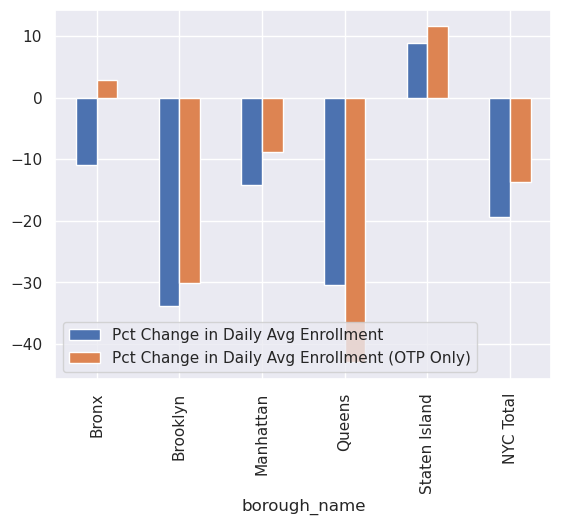

In [7]:
category_changes_df[['borough_name', 'Pct Change in Daily Avg Enrollment', 'Pct Change in Daily Avg Enrollment (OTP Only)']].plot(
    kind='bar',
    x='borough_name'
)

In [5]:
# Simplest possible view of OD deaths and OTP enrollment over time

sql = """
with e as (
    select
        year,
        SUM(c.avg_daily_enrollment) AS enrollment,
        SUM(case when p.program_category = 'Opioid Treatment Program'
            then c.avg_daily_enrollment end) as otp_enrollment
    from enrollment_by_year c
        left join programs p using (program_number)
    group by 1
),
ods as (
    select
        year,
        sum(deaths) as deaths
    from ny_county_od_trend
    where is_nyc
    group by 1
),
t as (
    select
        ods.year,
        e.enrollment,
        deaths,
        e_next.enrollment as next_e,
        e_prev.enrollment as prev_e,
        e_next.year as next_yr,
        e_prev.year as prev_yr
    from ods
        left join e using (year)
        left join lateral (
            select e_inner.year, enrollment 
            from e as e_inner
            where e_inner.year <= ods.year
            order by e_inner.year desc 
            limit 1
        ) e_prev ON TRUE
        left join lateral (
            select e_inner.year, enrollment 
            from e as e_inner
            where e_inner.year >= ods.year
            order by e_inner.year asc 
            limit 1
        ) e_next ON TRUE
),
interpolated as (
    select
        year,
        deaths,
        enrollment is null as is_interpolated,
        coalesce(
            enrollment,
            prev_e + (next_e - prev_e)::float * (year - prev_yr) / (next_yr - prev_yr)
        ) as enrollment_interpolated
    from t
)
select
    i.year,
    i.is_interpolated,
    case when i.enrollment_interpolated then 'yes' else 'no' end,
    100 * i.enrollment_interpolated :: float / t2010.enrollment as enrollment_pct_change,
    i.deaths,
    100 * i.deaths :: float / t2010.deaths as deaths_pct_change
from interpolated as i
    join t as t2010 on t2010.year = 2010
order by i.year
"""

nyc_enrollment_od_df = pd.read_sql(sql, con=db_url)
nyc_enrollment_od_df.head(3).T

,0,1,2
year,2010,2011,2012
is_interpolated,False,True,True
enrollment_interpolated,59553.0,59135.6,58718.2
enrollment_pct_change,100.0,99.299112,98.598223
deaths,385,450,520
deaths_pct_change,100.0,116.883117,135.064935


<AxesSubplot:xlabel='year'>

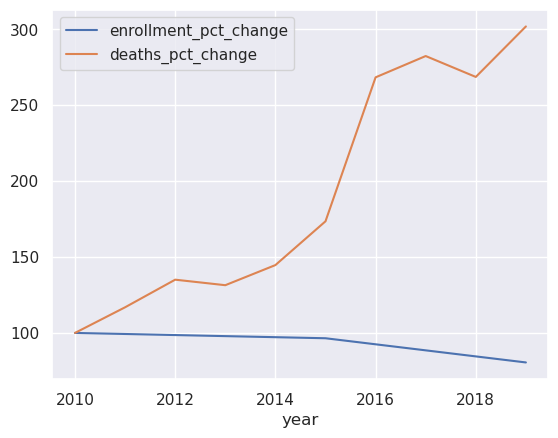

In [8]:
nyc_enrollment_od_df[['year', 'enrollment_pct_change', 'deaths_pct_change']].plot(
    kind='line',
    x='year'
);

In [3]:
sql = """
SELECT
    shelter_population.borough_name,
    borough_district_code,
    COALESCE(districts.district_name, 'Unknown') AS district_name,
    census_total AS "Sheltered in District",
    100 * census_total::float / sum(census_total) over () as "Fraction Sheltered in District",
    population_2020 AS "Population",
    100 * population_2020::float / sum(population_2020) over () AS "Fraction of Population",
    adult_shelter AS "Adult-only Sheltered",
    100 * adult_shelter::float / sum(adult_shelter) over ()AS "Fraction of Adult-only Sheltered",
    100 * adult_shelter::float / nullif(census_total, 0) AS "Adult-only Fraction of Sheltered",
    100000 * census_total ::float / population_2020 AS "Shelter Residents/100k",
    100000 * adult_shelter ::float / population_2020 AS "Adult-only Shelter Residents/100k"
FROM shelter_population
    JOIN districts USING (borough_district_code)
WHERE _is_most_recent_report
ORDER BY census_total DESC
"""

shelter_population_by_district = pd.read_sql(sql, con=db_url)
shelter_population_by_district.head(3).T

,0,1,2
borough_name,Brooklyn,Queens,Bronx
borough_district_code,316,412,204
district_name,Brownsville,"Jamaica, South Jamaica","Highbridge, Concourse"
Sheltered in District,3700,3688,2783
Fraction Sheltered in District,6.165845,6.145847,4.637715
Population,98506,256278,150436
Fraction of Population,1.118977,2.911185,1.708875
Adult-only Sheltered,626,271,423
Fraction of Adult-only Sheltered,4.394216,1.902288,2.969255
Adult-only Fraction of Sheltered,16.918919,7.348156,15.199425


In [4]:
sql = """
SELECT
    shelter_population.borough_name,
    100 * sum(census_total)::float / sum(sum(census_total)) over () as "Fraction of Sheltered",
    100 * sum(adult_shelter)::float / sum(sum(adult_shelter))  over () AS "Fraction of Adult-only Sheltered",
    100 * sum(population_2020)::float / sum(sum(population_2020)) over () AS "Fraction of Population",
    100 * sum(total_individuals_associated)::float / sum(sum(total_individuals_associated)) over () AS "Fraction of Shelter Associated Address",
    100000 * sum(census_total) ::float / sum(population_2020) AS "Shelter Residents/100k",
    100000 * sum(adult_shelter) ::float / sum(population_2020) AS "Adult-only Shelter Residents/100k"
FROM shelter_population
    JOIN districts USING (borough_district_code)
WHERE _is_most_recent_report
GROUP BY 1
"""
shelter_population_by_borough = pd.read_sql(sql, con=db_url)
shelter_population_by_borough.head(3).T

,0,1,2
borough_name,Queens,Brooklyn,Staten Island
Fraction of Sheltered,24.005133,30.204306,0.238302
Fraction of Adult-only Sheltered,10.276569,36.85245,0.0
Fraction of Population,27.367202,31.079968,5.624999
Shelter Residents/100k,597.917562,662.45425,28.878329
Adult-only Shelter Residents/100k,60.767186,191.8833,0.0


In [ ]:
sql = """
SELECT
    shelter_population.borough_name,
    100 * sum(census_total)::float / sum(sum(census_total)) over () as "Fraction of Sheltered",
    100 * sum(adult_shelter)::float / sum(sum(adult_shelter))  over () AS "Fraction of Adult-only Sheltered",
    100 * sum(population_2020)::float / sum(sum(population_2020)) over () AS "Fraction of Population",
    100 * sum(total_individuals_associated)::float / sum(sum(total_individuals_associated)) over () AS "Fraction of Shelter Associated Address",
    100000 * sum(census_total) ::float / sum(population_2020) AS "Shelter Residents/100k",
    100000 * sum(adult_shelter) ::float / sum(population_2020) AS "Adult-only Shelter Residents/100k"
FROM shelter_population
    JOIN districts USING (borough_district_code)
WHERE _is_most_recent_report
GROUP BY 1
"""
shelter_population_by_borough = pd.read_sql(sql, con=db_url)
shelter_population_by_borough.head(3).T

In [5]:
sql = """
SELECT
    report_date::date,
    sum(case when borough_name = 'Bronx' then census_total end) as "Bronx",
    sum(case when borough_name = 'Brooklyn' then census_total end) as "Brooklyn",
    sum(case when borough_name = 'Manhattan' then census_total end) as "Manhattan",
    sum(case when borough_name = 'Queens' then census_total end) as "Queens",
    sum(case when borough_name = 'Staten Island' then census_total end) as "Staten Island"
FROM shelter_population
WHERE census_total IS NOT NULL
GROUP BY 1
ORDER BY 1
"""
shelter_trend_by_borough = pd.read_sql(sql, con=db_url)
shelter_trend_by_borough.head(3).T

,0,1,2
report_date,2018-07-01 00:00:00-04:00,2018-08-01 00:00:00-04:00,2018-09-01 00:00:00-04:00
Bronx,19047,19384,19542
Brooklyn,16599,16638,16910
Manhattan,12994,13062,13131
Queens,10171,10403,10721
Staten Island,141,139,136
